In [1]:
from bs4 import BeautifulSoup
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import re
import pandas as pd  # Библиотека для табличек
from pandas import Series
import time
import browser_cookie3
import os
import sys
import datetime
import ast
import pdb
from sklearn import preprocessing
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns
from scipy.stats import ttest_ind
from itertools import combinations
from scipy.stats import (shapiro, probplot,
                         mannwhitneyu, ttest_ind,
                         pearsonr, f_oneway)
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold
# Machine Learning
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.ensemble import (ExtraTreesRegressor, RandomForestRegressor,
                              GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor, Pool

from tqdm.notebook import tqdm
from sklearn.base import clone

In [2]:
VERSION = 3

VAL_SIZE = 0.33   # 33%
N_FOLDS = 5
RANDOM_SEED = 42
# CATBOOST
ITERATIONS = 1000
LR = 0.15

In [3]:
sample_submission = pd.read_csv('sample_submission.csv')
df_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', 70)
# df_test.head(5)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

### Парсинг и подготовка обучающего датасета

Парсинг оказался самым трудоемким из всего задания, что мне кажется не совсем правильным. Потрачено больше недели. 
В основном на борьбу с зависаниями запросов. Опыт конечно полезный, но не адекватный затраченному времени.
Может быть лучше провести тренировку на небольшом датасете. А для ML иметь датасет спарсенный для всех. 
Сайт auto.ru и так видимо уже стал бороться с парсингом. 
В итоге вместо тщательной проработки ML мы тратим время (в большой степени избыточно) на парсинг. 

In [4]:
df_train = pd.read_csv('train.csv')
# df_train.head(5)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40054 entries, 0 to 40053
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              40054 non-null  object 
 1   brand                 40054 non-null  object 
 2   car_url               40054 non-null  object 
 3   color                 40054 non-null  object 
 4   complectation_dict    7931 non-null   object 
 5   description           40054 non-null  object 
 6   engineDisplacement    40054 non-null  object 
 7   enginePower           40054 non-null  object 
 8   equipment_dict        30252 non-null  object 
 9   fuelType              40054 non-null  object 
 10  image                 0 non-null      float64
 11  mileage               40054 non-null  int64  
 12  modelDate             40054 non-null  int64  
 13  model_info            40054 non-null  object 
 14  model_name            40054 non-null  object 
 15  name               

## Анализ и преобразование признаков. 

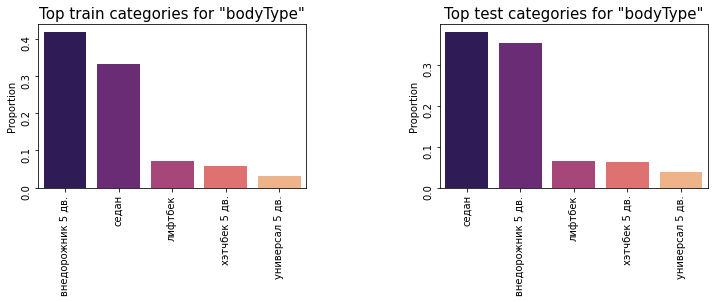

In [7]:
def bar(column, n):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    """
    Plots pie chart and bar chart
    for given categorical feature
    """
    df = df_train
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    sns.barplot(x=df[column].astype(str).value_counts().index[:n],
                y=df[column].value_counts(normalize=True).values[:n],
                palette='magma', ax=axes.flat[0])
    ax = axes.flat[0]
    ax.set_title(f'Top train categories for "{column}"',
                 size=15)
    ax.set_ylabel('Proportion')
    ax.tick_params(rotation=90)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    df = df_test
    sns.barplot(x=df[column].astype(str).value_counts().index[:n],
                y=df[column].value_counts(normalize=True).values[:n],
                palette='magma', ax=axes.flat[1])
    ax = axes.flat[1]
    ax.set_title(f'Top test categories for "{column}"',
                 size=15)
    ax.set_ylabel('Proportion')
    ax.tick_params(rotation=90)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    # ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

    plt.subplots_adjust(wspace=0.5)


bar('bodyType', 5)

In [8]:
# Закодируем категориальный признак 'bodyType' единым образом (объединим множества встречающихся значений) для test и train датасетов.
bodyTypes = list(set(np.unique(df_test['bodyType'])) | set(
    np.unique(df_train['bodyType'])))
le = preprocessing.LabelEncoder()
le.fit(bodyTypes)
df_test['bodyType'] = le.transform(df_test['bodyType'])
df_train['bodyType'] = le.transform(df_train['bodyType'])
le.classes_

array(['внедорожник 3 дв.', 'внедорожник 5 дв.', 'внедорожник открытый',
       'кабриолет', 'компактвэн', 'купе', 'купе-хардтоп', 'лимузин',
       'лифтбек', 'микровэн', 'минивэн', 'пикап двойная кабина',
       'пикап одинарная кабина', 'пикап полуторная кабина', 'родстер',
       'седан', 'седан 2 дв.', 'седан-хардтоп', 'тарга',
       'универсал 3 дв.', 'универсал 5 дв.', 'фастбек', 'фургон',
       'хэтчбек 3 дв.', 'хэтчбек 5 дв.'], dtype='<U23')

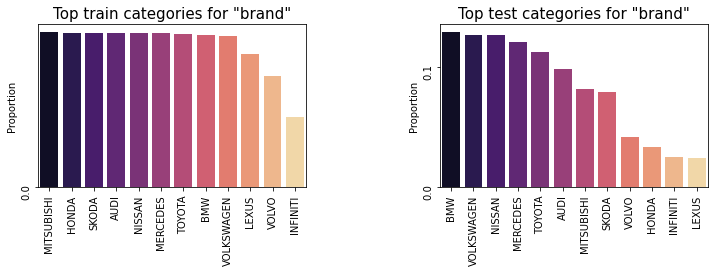

In [9]:
bar('brand', 12)

In [10]:
# Кодируем brands
le.fit(df_test['brand'])
df_train['brand'] = le.transform(df_train['brand'])
df_test['brand'] = le.transform(df_test['brand'])
le.classes_

array(['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES',
       'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO'],
      dtype=object)

In [11]:
# 'car_url' не используется и будет удален из датасета
df_train.drop(columns=['car_url'], inplace=True)
df_test.drop(columns=['car_url'], inplace=True)

In [12]:
# Закодируем категориальный признак 'color'
colors = np.unique(df_test['color'])
le = preprocessing.LabelEncoder()
le.fit(colors)
df_test['color'] = le.transform(df_test['color'])
df_train['color'] = le.transform(df_train['color'])
le.classes_

array(['бежевый', 'белый', 'голубой', 'жёлтый', 'зелёный', 'золотистый',
       'коричневый', 'красный', 'оранжевый', 'пурпурный', 'розовый',
       'серебристый', 'серый', 'синий', 'фиолетовый', 'чёрный'],
      dtype=object)

In [13]:
# Создадим новый признак
df_train['complectation_dict'] = df_train['complectation_dict'].apply(lambda x: np.nan if pd.isna(x)
                                                                      else ast.literal_eval(x)['available_options'])
df_test['complectation_dict'] = df_test['complectation_dict'].apply(lambda x: np.nan if pd.isna(x)
                                                                    else json.loads(x)['available_options'])
df_train['comp_length'] = df_train['complectation_dict'].apply(
    lambda x: 0 if x != x else len(x))
df_test['comp_length'] = df_test['complectation_dict'].apply(
    lambda x: 0 if x != x else len(x))

<AxesSubplot:>

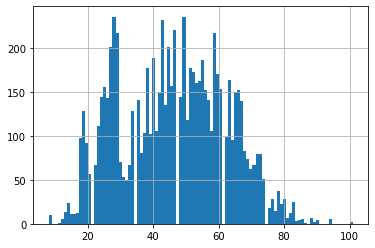

In [14]:
df_train[df_train['comp_length'] > 0]['comp_length'].hist(bins=100)

<AxesSubplot:>

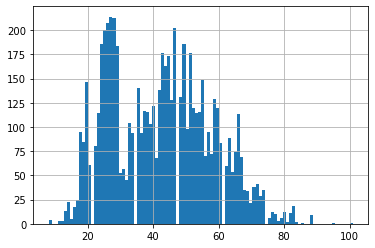

In [15]:
df_test[df_test['comp_length'] > 0]['comp_length'].hist(bins=100)

In [16]:
# Закодируем наличие 'complectation_dict' как бинарный категориальный признак
df_train.loc[df_train['complectation_dict'].notna(), 'complectation_dict'] = 1
df_train['complectation_dict'].fillna(0, inplace=True)
df_test.loc[df_test['complectation_dict'].notna(), 'complectation_dict'] = 1
df_test['complectation_dict'].fillna(0, inplace=True)

In [17]:
# 'description' - повод для текстового анализа, пока решено  не использовать. будет удален из датасета
df_train.drop(columns=['description'], inplace=True)
df_test.drop(columns=['description'], inplace=True)

In [18]:
# кновертируем в числовые значения литраж двигателя
df_train.loc[df_train['engineDisplacement'] == ' LTR',
             'engineDisplacement'] = '0.0 LTR'  # у электрокаров нет литража
df_train['engineDisplacement'] = df_train.engineDisplacement.str.split(expand=True)[
    0].astype(float)
df_test.loc[df_test['engineDisplacement'] == ' LTR',
            'engineDisplacement'] = '0.0 LTR'  # у электрокаров нет литража
df_test['engineDisplacement'] = df_test.engineDisplacement.str.split(expand=True)[
    0].astype(float)

In [19]:
# конвертируем в числовые значения мощность двигателя
df_train['enginePower'] = df_train.enginePower.str.split(expand=True)[
    0].astype(int)
df_test['enginePower'] = df_test.enginePower.str.split(expand=True)[
    0].astype(int)

In [20]:
# Создадим новый признак
df_train['equipment_dict'] = df_train['equipment_dict'].apply(lambda x: np.nan if pd.isna(x)
                                                              else ast.literal_eval(x))
df_test['equipment_dict'] = df_test['equipment_dict'].apply(lambda x: np.nan if pd.isna(x)
                                                            else json.loads(x))
df_train['eq_length'] = df_train['equipment_dict'].apply(
    lambda x: 0 if x != x else len(x))
df_test['eq_length'] = df_test['equipment_dict'].apply(
    lambda x: 0 if x != x else len(x))

<AxesSubplot:>

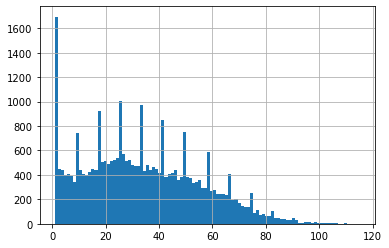

In [21]:
df_train[df_train['eq_length'] > 0]['eq_length'].hist(bins=100)

<AxesSubplot:>

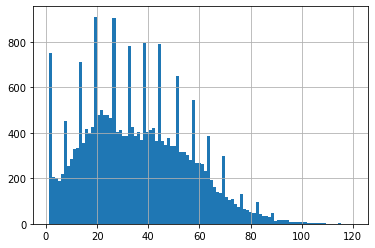

In [22]:
df_test[df_test['eq_length'] > 0]['eq_length'].hist(bins=100)

In [23]:
# Закодируем наличие 'equipment_dict'как бинарный категориальный признак
df_train.loc[df_train['equipment_dict'].notna(), 'equipment_dict'] = 1
df_train['equipment_dict'].fillna(0, inplace=True)
df_test.loc[df_test['equipment_dict'].notna(), 'equipment_dict'] = 1
df_test['equipment_dict'].fillna(0, inplace=True)

In [24]:
# Закодируем категориальный признак 'fuelType'
fuelTypes = np.unique(df_test['fuelType'])
le = preprocessing.LabelEncoder()
le.fit(fuelTypes)
df_test['fuelType'] = le.transform(df_test['fuelType'])
df_train['fuelType'] = le.transform(df_train['fuelType'])
le.classes_  # array(['бензин', 'газ', 'гибрид', 'дизель', 'электро']

array(['бензин', 'газ', 'гибрид', 'дизель', 'электро'], dtype=object)

In [25]:
# 'mileage' - числовой прирзнак, сохраняем как есть
# 'modelDate' - числовой прирзнак, сохраняем как есть
# 'model_info' - не добавляет информации, и будет удален
df_train.drop(columns=['model_info'], inplace=True)
df_test.drop(columns=['model_info'], inplace=True)

In [26]:
# model_name - категориальный признак. Проблема в том, что множество моделей в тесте и трейне отличается.
# Отношение количества моделей общих для теста и трейна к общему количеству моделей (из теста и трейна вместе взятых) - 0.77
len(set(np.unique(df_train['model_name'])) & set(np.unique(df_test['model_name']))) / \
    len(set(np.unique(df_train['model_name']))
        | set(np.unique(df_test['model_name'])))

0.7793650793650794

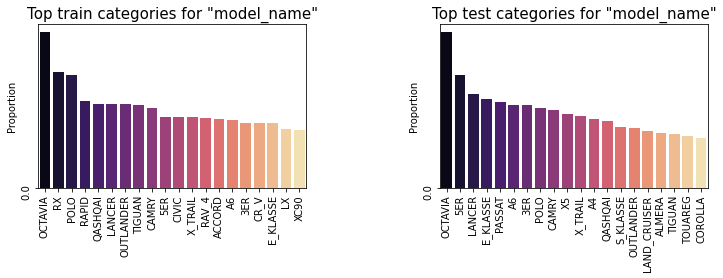

In [27]:
bar('model_name', 20)

In [28]:
# Количество моделей в тесте про которые мы ничего не узнаем из трейна:
test_model = set(np.unique(df_test['model_name'])) - \
    set(np.unique(df_train['model_name']))
sum(df_test.model_name.isin(test_model))

114

In [29]:
# Количество моделей в трейне, которых нет в тесте:
train_model = set(np.unique(df_train['model_name'])) - \
    set(np.unique(df_test['model_name']))
sum(df_train.model_name.isin(train_model))

233

In [30]:
# '''# Очевидно (в виду незначительных различий 233 и 114) можно объединить множества моделей и провести кодирование
model_names = list(set(np.unique(df_test['model_name'])) | set(
    np.unique(df_train['model_name'])))
le = preprocessing.LabelEncoder()
le.fit(model_names)
df_test['model_name'] = le.transform(df_test['model_name'])
df_train['model_name'] = le.transform(df_train['model_name'])
# Может показаться, что нехорошо подглядывать в тест, однако мы "подглядываем" в рамках разработки, когда нам необходимо
# узнать все возможные значения моделей - а это можно сделать, только собрав вообще всю базу по машинам. Но так как за счет тестового датасета
# мы можем просто расширить наше знание - думаю это легальный путь.

# '''
# Непонятно, что с этим признаком делать - множества в трейне и тесте пересекаются, но далеко не полностью -
# отношение количества моделей общих для теста и трейна к общему количеству моделей (из теста и трейна вместе взятых) - 0.77
# пока удаляем
# df_train.drop('model_name',axis=1,inplace=True)
# df_test.drop('model_name',axis=1,inplace=True)

In [31]:
# 'name'  - не добавляет информации, и будет удален
df_train.drop(columns=['name'], inplace=True)
df_test.drop(columns=['name'], inplace=True)

In [32]:
# numberOfDoors - числовой прирзнак, сохраняем как есть
# priceCurrency - везде const=='RUB', удаляем
df_train.drop(columns=['priceCurrency'], inplace=True)
df_test.drop(columns=['priceCurrency'], inplace=True)

In [33]:
# Используем 'parsing_unixtime' для определения возраста автомобиля:
d1 = pd.to_datetime(df_test['parsing_unixtime'], unit='s')
print('The parsing was going on for a week since',
      d1.min().date(), 'till', d1.max().date())

d1 = pd.to_datetime(df_test['parsing_unixtime'], unit='s')
d2 = pd.to_datetime(df_test.productionDate, format='%Y')  # [0].date()
df_test['age'] = ((d1-d2).dt.days/365).round(decimals=0).astype(int)

d1 = pd.to_datetime(df_train['parsing_unixtime'], unit='s')
d2 = pd.to_datetime(df_train.productionDate, format='%Y')  # [0].date()
df_train['age'] = ((d1-d2).dt.days/365).round(decimals=0).astype(int)

The parsing was going on for a week since 2020-10-19 till 2020-10-26


<AxesSubplot:>

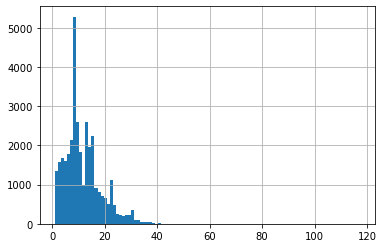

In [34]:
df_test['age'].hist(bins=100)

<AxesSubplot:>

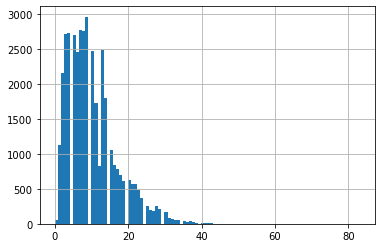

In [35]:
df_train['age'].hist(bins=100)

In [36]:
# Удаляем использованные признаки
df_train.drop(columns=['parsing_unixtime'], inplace=True)
df_test.drop(columns=['parsing_unixtime'], inplace=True)
df_train.drop(columns=['productionDate'], inplace=True)
df_test.drop(columns=['productionDate'], inplace=True)

In [37]:
# Проверим наличие дубликатов с помощью 'sell_id'
sum(df_test.duplicated(subset=['sell_id']))
sum(df_test.duplicated(subset=['sell_id']))
# Удаляем использованный признак
df_train.drop(columns=['sell_id'], inplace=True)
df_test.drop(columns=['sell_id'], inplace=True)

In [38]:
# 'super_gen' содержит (помимо уже доступных признаков в других столбцах) такие  признаки как:
# "acceleration","clearance_min","clearance_mах","fuel_rate". Эти признаки уже доступны в трейн датасете
# Извлечем их в отдельные столбцы тестового датасета:
d = []
for i in df_test.super_gen.to_list():
    d.append(ast.literal_eval(i))
df_test[['acceleration', 'fuel_rate', 'clearance_min', 'clearance_max']] = pd.DataFrame(
    d)[['acceleration', 'fuel_rate', 'clearance_min', 'clearance_max']]
# Удаляем использованный признак
df_train.drop(columns=['super_gen'], inplace=True)
df_test.drop(columns=['super_gen'], inplace=True)

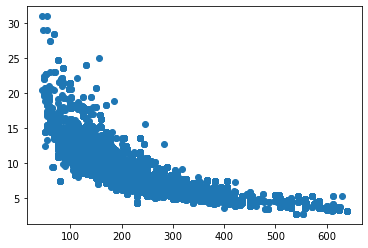

In [39]:
# Попробуем заполнить пустые значения 'acceleration' на основании мощности двигателя
import matplotlib.pyplot as plt
eng_pwr = df_train.loc[df_train.acceleration.notna(
), 'enginePower'].values.reshape(-1, 1)
accel = df_train.loc[df_train.acceleration.notna(
), 'acceleration'].values.reshape(-1, 1)
plt.scatter(eng_pwr, accel)

In [40]:
Xtrain = (df_train.loc[df_train.acceleration.notna(),
                       'enginePower'].values.reshape(-1, 1))
Xtrain.shape
x = test_data = np.hstack([Xtrain, Xtrain])
x.shape

(38080, 2)

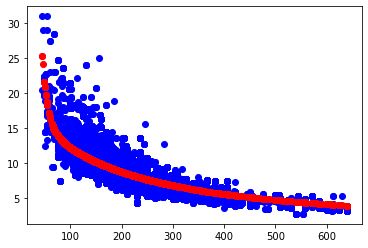

In [41]:
# Можно предположить зависимость ускорения (на самом деле времени разгона до 100км/ч) от мощности как ~1/x
from sklearn.linear_model import LinearRegression

Xtrain = (df_train.loc[df_train.acceleration.notna(),
                       'enginePower'].values.reshape(-1, 1))
x1 = 1/Xtrain
x2 = 1/Xtrain**2
x3 = 1/Xtrain**0.5
x4 = 1/Xtrain**3

x = np.hstack([x1, x2, x3, x4])
Ytrain = df_train.loc[df_train.acceleration.notna(
), 'acceleration'].values.reshape(-1, 1)
lr = LinearRegression()
lr.fit(x, Ytrain)
y_pred = lr.predict(x)
# Проверим
plt.scatter(eng_pwr, accel, color='b', label='true')
plt.scatter(Xtrain, y_pred, color='r', label='pred')

In [42]:
lr.coef_

array([[ 1.50120278e+03, -1.28845222e+05,  6.52985035e+01,
         4.23186304e+06]])

In [43]:
# Заполним пустые значения 'acceleration' на основании мощности двигателя для обоих датасетов:
Xtest = df_train.loc[df_train.acceleration.isna(
), 'enginePower'].values.reshape(-1, 1)
x1 = 1/Xtest
x2 = 1/Xtest**2
x3 = 1/Xtest**0.5
x4 = 1/Xtest**3
x = np.hstack([x1, x2, x3, x4])
df_train.loc[df_train.acceleration.isna(), 'acceleration'] = lr.predict(x)

Xtest = df_test.loc[df_test.acceleration.isna(
), 'enginePower'].values.reshape(-1, 1)
x1 = 1/Xtest
x2 = 1/Xtest**2
x3 = 1/Xtest**0.5
x4 = 1/Xtest**3
x = np.hstack([x1, x2, x3, x4])
df_test.loc[df_test.acceleration.isna(), 'acceleration'] = lr.predict(x)

# Ограничим 'acceleration' сверху из тех соображений, что для слабых двигателей этот показатель уже не играет никакой роли
df_train.loc[df_train.acceleration > 60, 'acceleration'] = 60
df_test.loc[df_test.acceleration > 60, 'acceleration'] = 60

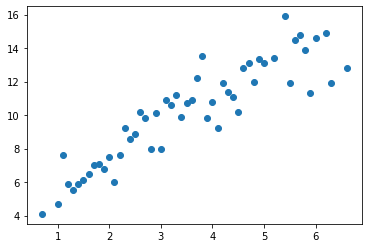

In [44]:
# Для заполнения пустых значений 'fuel_rate' (<10%) можно конечно, использовать медиану, но для большей точности попоробуем
# использовать медианы по каждому значению объема двигателя:
eng_displ = np.array(df_train[(df_train.fuel_rate.notna()) & (df_train.fuelType != 4)].groupby(
    'engineDisplacement')['fuel_rate'].median().keys()).reshape(-1, 1)
fuel_rate = df_train[(df_train.fuel_rate.notna()) & (df_train.fuelType != 4)].groupby(
    'engineDisplacement')['fuel_rate'].median().values.reshape(-1, 1)
plt.scatter(eng_displ, fuel_rate)

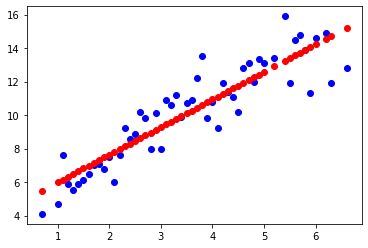

In [45]:
# Построим линейную регрессию использовав числовую упорядоченность категориального признака 'engineDisplacement'
lr = LinearRegression()
lr.fit(eng_displ, fuel_rate)
y_pred = lr.predict(eng_displ)
plt.scatter(eng_displ, fuel_rate, color='b', label='true')
plt.scatter(eng_displ, y_pred, color='r', label='pred')

In [46]:
# Для электрокаров заполним пустые значения 'fuel_rate'=0:
df_train.loc[df_train.fuelType == 4, 'fuel_rate'].fillna(0, inplace=True)
df_test.loc[df_test.fuelType == 4, 'fuel_rate'].fillna(0, inplace=True)

# Заполним пустые значения 'fuel_rate' полученной регрессией объема двигателя для обоих датасетов:
x = df_train.loc[df_train.fuel_rate.isna(
), 'engineDisplacement'].values.reshape(-1, 1)
df_train.loc[df_train.fuel_rate.isna(), 'fuel_rate'] = lr.predict(x)

x = df_test.loc[df_test.fuel_rate.isna(
), 'engineDisplacement'].values.reshape(-1, 1)
df_test.loc[df_test.fuel_rate.isna(), 'fuel_rate'] = lr.predict(x)

In [47]:
# Заполним пустые значения 'clearance_min' с помощью медианы клиренса для каждого типа кузова:
median_by_bodyType_list = df_train.groupby(
    'bodyType')['clearance_min'].median()
for b in np.unique(df_train.bodyType):
    df_train.loc[(df_train.clearance_min.isna()) & (
        df_train.bodyType == b), 'clearance_min'] = median_by_bodyType_list[b]
    df_test.loc[(df_test.clearance_min.isna()) & (
        df_test.bodyType == b), 'clearance_min'] = median_by_bodyType_list[b]

# Вариант 1
# Заполним пустые значения 'clearance_max' значениями 'clearance_min' (можно также вообще удалить этот признак):
# df_train.loc[df_train.clearance_max.isna(),'clearance_max']=df_train.clearance_min
# df_test.loc[df_test.clearance_max.isna(),'clearance_max']=df_test.clearance_min

# Вариант 2
# Заполним пустые значения 'clearance_max' значениями '0' :
# df_train['clearance_max'].fillna(0,inplace=True)
# df_test['clearance_max'].fillna(0,inplace=True)

# Вариант 3
# Преобразуем 'clearance_max' в категориальный признак:
df_test.clearance_max.fillna(0, inplace=True)
df_test.loc[df_test.clearance_max.between(1, 220), 'clearance_max'] = 1
df_test.loc[df_test.clearance_max.between(225, 280), 'clearance_max'] = 2
df_test.loc[df_test.clearance_max > 280, 'clearance_max'] = 3

df_train.clearance_max.fillna(0, inplace=True)
df_train.loc[df_train.clearance_max.between(1, 220), 'clearance_max'] = 1
df_train.loc[df_train.clearance_max.between(225, 280), 'clearance_max'] = 2
df_train.loc[df_train.clearance_max > 280, 'clearance_max'] = 3

In [48]:
# 'vehicleConfiguration'  - не добавляет информации, и будет удален
df_train.drop(columns=['vehicleConfiguration'], inplace=True)
df_test.drop(columns=['vehicleConfiguration'], inplace=True)

# Закодируем категориальный признак 'vehicleTransmission'
vehicleTransmissions = np.unique(df_test['vehicleTransmission'])
le = preprocessing.LabelEncoder()
le.fit(vehicleTransmissions)
df_test['vehicleTransmission'] = le.transform(df_test['vehicleTransmission'])
df_train['vehicleTransmission'] = le.transform(df_train['vehicleTransmission'])
le.classes_

array(['автоматическая', 'вариатор', 'механическая', 'роботизированная'],
      dtype=object)

In [49]:
# Закодируем наличие 'vendor' как бинарный категориальный признак
df_train.loc[df_train['vendor'] == 'EUROPEAN', 'vendor'] = 1
df_train.loc[df_train['vendor'] == 'JAPANESE', 'vendor'] = 0
df_test.loc[df_test['vendor'] == 'EUROPEAN', 'vendor'] = 1
df_test.loc[df_test['vendor'] == 'JAPANESE', 'vendor'] = 0

In [50]:
# Закодируем категориальный признак 'Владельцы' и переименуем его в 'owners_number'
owners_numbers = np.unique(df_test['Владельцы'].str.split(expand=True)[0])
le = preprocessing.LabelEncoder()
le.fit(owners_numbers)
df_test['owners_number'] = le.transform(
    df_test['Владельцы'].str.split(expand=True)[0])
df_train['owners_number'] = le.transform(
    df_train['Владельцы'].str.split(expand=True)[0])
df_train.drop(columns=['Владельцы'], inplace=True)
df_test.drop(columns=['Владельцы'], inplace=True)
le.classes_

array(['1', '2', '3'], dtype=object)

<AxesSubplot:>

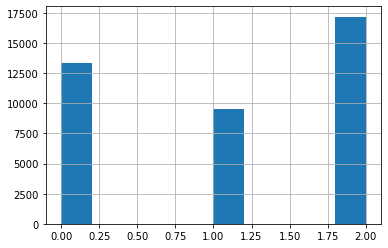

In [51]:
df_train['owners_number'].hist()

In [52]:
# Конвертируем признак 'Владение' в числовой (количество месяцев) и переименуем его в 'owning'
dft = df_test['Владение'].str.split(' и ', expand=True)
dfy = dft[0].str.split(expand=True)[0].astype(float)
dfm = dft[1].str.split(expand=True)[0].astype(float)
df_test['owning'] = dfy*12+dfm
df_test.fillna(0, inplace=True)
df_test.drop(columns=['Владение'], inplace=True)

dft = df_train['Владение'].str.split(' и ', expand=True)
dfy = dft[0].str.split(expand=True)[0].astype(float)
dfm = dft[1].str.split(expand=True)[0].astype(float)
df_train['owning'] = dfy*12+dfm
df_train.fillna(0, inplace=True)
df_train.drop(columns=['Владение'], inplace=True)

In [53]:
# Закодируем наличие 'ПТС' как бинарный категориальный признак и переименуем его в 'pts'

df_train.loc[df_train['ПТС'] == 'Оригинал', 'ПТС'] = 0
df_train.loc[df_train['ПТС'] == 'Дубликат', 'ПТС'] = 1
df_test.loc[df_test['ПТС'] == 'Оригинал', 'ПТС'] = 0
df_test.loc[df_test['ПТС'] == 'Дубликат', 'ПТС'] = 1
df_test['pts'] = df_test['ПТС'].astype(int)
df_train['pts'] = df_train['ПТС'].astype(int)

df_test.drop(columns=['ПТС'], inplace=True)
df_train.drop(columns=['ПТС'], inplace=True)

In [54]:
# Закодируем категориальный признак 'Привод' и переименуем его в 'gearType'
gearTypes = np.unique(df_test['Привод'])
le = preprocessing.LabelEncoder()
le.fit(gearTypes)
df_test['gearType'] = le.transform(df_test['Привод'])
df_train['gearType'] = le.transform(df_train['Привод'])

df_test.drop(columns=['Привод'], inplace=True)
df_train.drop(columns=['Привод'], inplace=True)

le.classes_

array(['задний', 'передний', 'полный'], dtype=object)

In [55]:
# Закодируем наличие 'Руль' как бинарный категориальный признак и переименуем его в 'steering_wheel'

df_train.loc[df_train['Руль'] == 'Левый', 'Руль'] = 0
df_train.loc[df_train['Руль'] == 'Правый', 'Руль'] = 1
df_test.loc[df_test['Руль'] == 'Левый', 'Руль'] = 0
df_test.loc[df_test['Руль'] == 'Правый', 'Руль'] = 1
df_test['steering_wheel'] = df_test['Руль'].astype(int)
df_train['steering_wheel'] = df_train['Руль'].astype(int)

df_test.drop(columns=['Руль'], inplace=True)
df_train.drop(columns=['Руль'], inplace=True)

In [56]:
# Признаки 'Таможня' и 'Состояние' не информативны, удаляем.
df_train.drop(columns=['Таможня'], inplace=True)
df_test.drop(columns=['Таможня'], inplace=True)
df_train.drop(columns=['Состояние'], inplace=True)
df_test.drop(columns=['Состояние'], inplace=True)
# 'complectation' - лишний признак из трейна
df_train.drop(columns=['complectation'], inplace=True)
# удаляем 'image'
df_train.drop(columns=['image'], inplace=True)
df_test.drop(columns=['image'], inplace=True)

In [57]:
# Mean_target_value encoding.
for col in ['model_name', 'brand', 'bodyType', 'engineDisplacement', 'enginePower']:
    col_classes = list(set(np.unique(df_test[col])) | set(
        np.unique(df_train[col])))  # получим все возможные значения признаков для теста и трейна
    zero_dict = dict.fromkeys(col_classes, 0)  # предварительно заполним нулями
    mean_dict = df_train.groupby([col])['Price'].mean().to_dict()
    col_means = {**zero_dict, **mean_dict}
    df_train[col + '_' + 'price'] = df_train[col].apply(lambda x: col_means[x])
    df_test[col + '_' + 'price'] = df_test[col].apply(lambda x: col_means[x])

<AxesSubplot:>

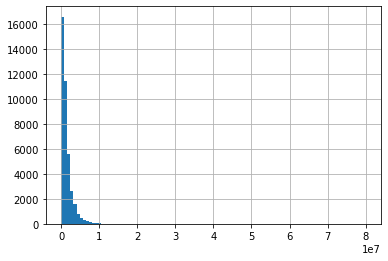

In [58]:
# Синхронизируем порядок столбцов у датасетов
df_train = df_train.reindex(columns=df_test.columns.to_list()+['Price'])

# Целевая переменная имеет двольно смещенное распределение
df_train.Price.hist(bins=100)

<AxesSubplot:>

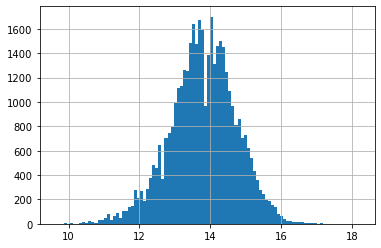

In [59]:
# Проведем логарифмирование и получим распределение близкое к нормальному.
# в итоге значительно улучшило результат
df_train.Price = np.log(df_train.Price)
df_train.Price.hist(bins=100)

In [60]:
df_train.Price.describe()

count    40054.000000
mean        13.793220
std          0.927789
min          9.615805
25%         13.217674
50%         13.805460
75%         14.403297
max         18.197537
Name: Price, dtype: float64

In [61]:
# my
num_cols = ['enginePower', 'acceleration', 'clearance_min',
            'fuel_rate', 'mileage', 'modelDate', 'age']
cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType',
            'numberOfDoors', 'vehicleTransmission', 'gearType', 'owners_number', 'clearance_max']
bin_cols = ['complectation_dict', 'equipment_dict',
            'vendor', 'pts', 'steering_wheel']
# Проверка
set(df_train.columns.to_list())-(set(num_cols) | set(cat_cols) | set(bin_cols))

{'Price',
 'bodyType_price',
 'brand_price',
 'comp_length',
 'engineDisplacement_price',
 'enginePower_price',
 'eq_length',
 'model_name',
 'model_name_price',
 'owning'}

In [62]:
# exper
num_cols = ['enginePower', 'mileage', 'modelDate',  'age', 'acceleration',
            'fuel_rate', 'clearance_min', 'comp_length', 'eq_length', 'owning', 'model_name_price', 'brand_price', 'bodyType_price', 'engineDisplacement_price', 'enginePower_price']
cat_cols = ['clearance_max', 'model_name', 'bodyType', 'brand', 'color', 'engineDisplacement',
            'fuelType', 'numberOfDoors', 'vehicleTransmission', 'gearType', 'owners_number', ]
bin_cols = ['equipment_dict', 'vendor', 'pts', 'steering_wheel']
# Неиспользуемые признаки в df_train:
set(df_train.columns.to_list())-(set(num_cols) |
                                 set(cat_cols) | set(bin_cols) | set(['Price']))

{'complectation_dict'}

## Анализ значимости признаков

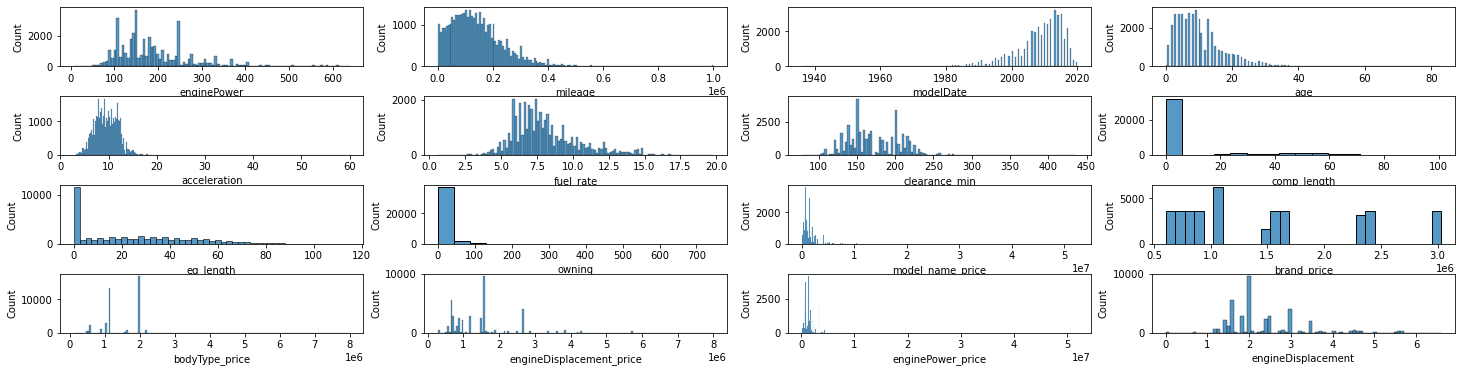

In [63]:
cols = num_cols+['engineDisplacement']
v = int(np.ceil(len(cols)/4))

fig, axes = plt.subplots(v, 4, figsize=(25, 6))
for col, i in zip(cols, range(len(cols))):
    sns.histplot(df_train[col], kde=False, ax=axes.flat[i])
plt.subplots_adjust(hspace=0.5)

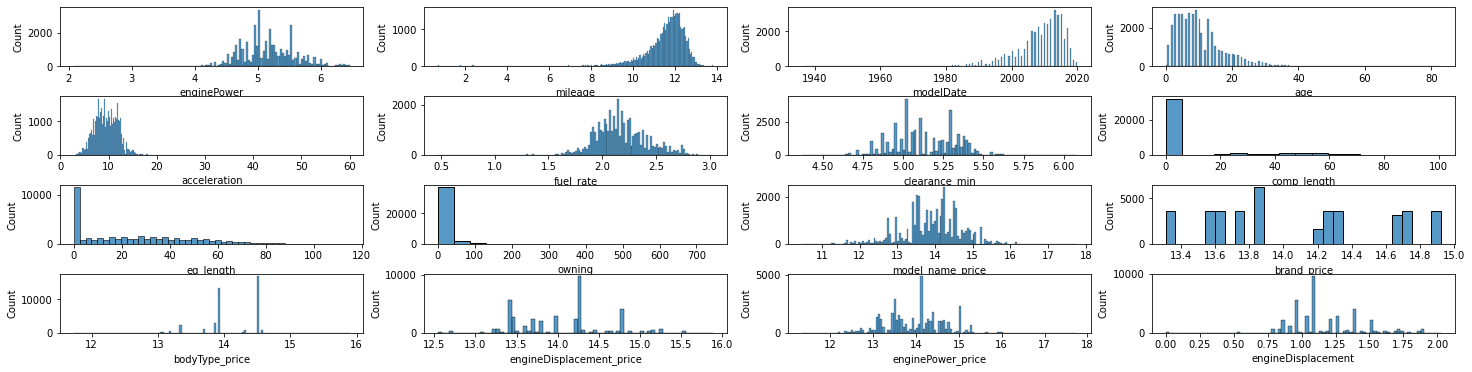

In [64]:
# логарифмируем некоторые числовые признаки, чтобы их распределения были подобны нормальным (для деревьев не принципиально)
num_cols_to_transfrom = ['enginePower',
                         'clearance_min', 'fuel_rate', 'mileage', 'engineDisplacement', 'model_name_price', 'brand_price', 'bodyType_price', 'engineDisplacement_price', 'enginePower_price']
for nc in num_cols_to_transfrom:
    df_train[nc] = np.log(df_train[nc]+1)
    df_test[nc] = np.log(df_test[nc]+1)

cols = num_cols+['engineDisplacement']
v = int(np.ceil(len(cols)/4))

fig, axes = plt.subplots(v, 4, figsize=(25, 6))
for col, i in zip(num_cols+['engineDisplacement'], range(len(num_cols+['engineDisplacement']))):
    sns.histplot(df_train[col], kde=False, ax=axes.flat[i])
plt.subplots_adjust(hspace=0.5)

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

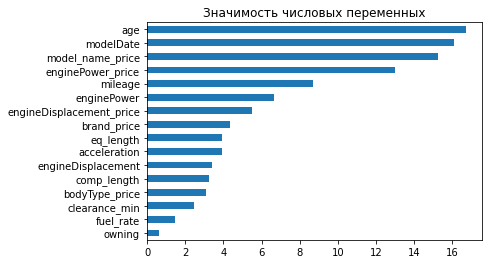

In [65]:
imp_num = pd.Series(f_classif(df_train[num_cols+['engineDisplacement']], df_train['Price'])[
                    0], index=num_cols+['engineDisplacement'])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Значимость числовых переменных')

Text(0.5, 1.0, 'Correlation matrix')

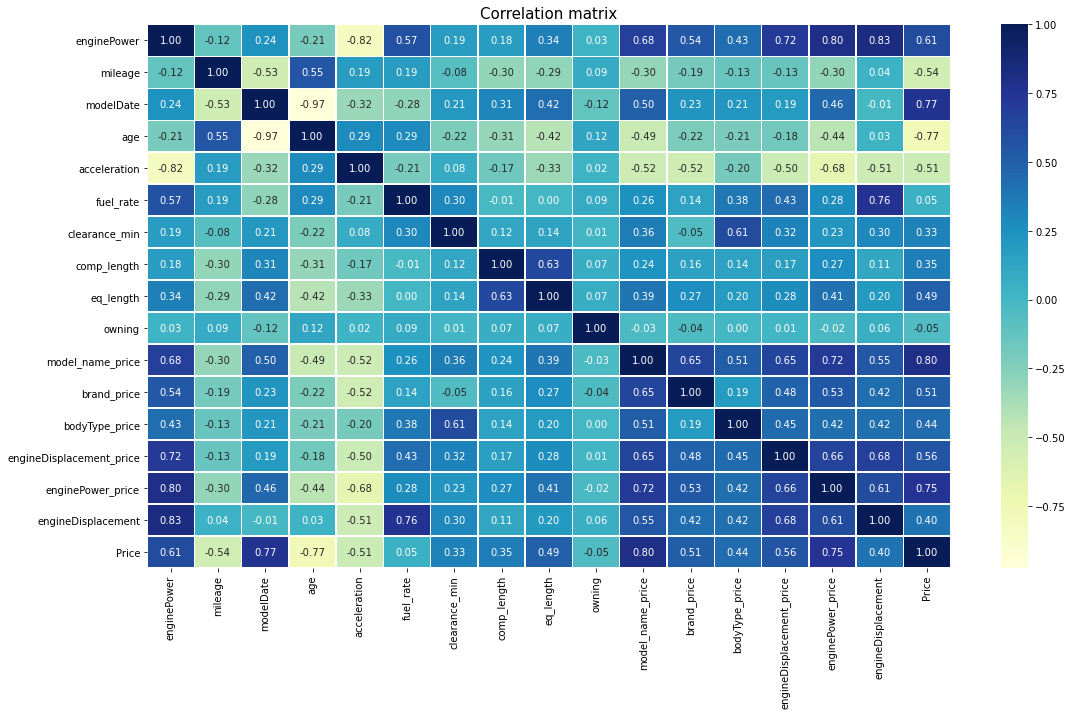

In [66]:
# Посмотрим на корреляции, хотя в случае решающих деревьев этот анализ не так важен
plt.figure(figsize=(18, 10))
sns.heatmap(df_train[num_cols+['engineDisplacement']+['Price']].corr(), annot=True,
            fmt='.2f', cmap='YlGnBu', linewidth=0.5)
plt.title('Correlation matrix', size=15)

In [67]:
# Удостоверимся в значимости выбранных категориальных признаков
def get_stat_dif(column):
    df = df_train.copy()
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    # print(len(combinations_all))
    alfa = 0.05
    for comb in combinations_all:
        p_value = ttest_ind(df.loc[df.loc[:, column] == comb[0], 'Price'],
                            df.loc[df.loc[:, column] == comb[1], 'Price']).pvalue
        if p_value <= alfa/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия: pvalue =',
                  round(p_value, 4), ' < ', alfa/len(combinations_all), ' для', column)
            stat_list.append(column)
            break


stat_list = []  # создадим список для статистически значимых номинативных переменных
for col in cat_cols+bin_cols:
    # Все кат и бин признаки признаны статистически значимыми
    get_stat_dif(col)

Найдены статистически значимые различия: pvalue = 0.0  <  0.008333333333333333  для clearance_max
Найдены статистически значимые различия: pvalue = 0.0  <  3.0088580781821686e-07  для model_name
Найдены статистически значимые различия: pvalue = 0.0  <  0.0001666666666666667  для bodyType
Найдены статистически значимые различия: pvalue = 0.0  <  0.0007575757575757576  для brand
Найдены статистически значимые различия: pvalue = 0.0001  <  0.0004166666666666667  для color
Найдены статистически значимые различия: pvalue = 0.0  <  3.3670033670033675e-05  для engineDisplacement
Найдены статистически значимые различия: pvalue = 0.0  <  0.005  для fuelType
Найдены статистически значимые различия: pvalue = 0.0  <  0.008333333333333333  для numberOfDoors
Найдены статистически значимые различия: pvalue = 0.0  <  0.008333333333333333  для vehicleTransmission
Найдены статистически значимые различия: pvalue = 0.0  <  0.016666666666666666  для gearType
Найдены статистически значимые различия: pvalue 

In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40054 entries, 0 to 40053
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bodyType                  40054 non-null  int32  
 1   brand                     40054 non-null  int32  
 2   color                     40054 non-null  int32  
 3   complectation_dict        40054 non-null  int64  
 4   engineDisplacement        40054 non-null  float64
 5   enginePower               40054 non-null  float64
 6   equipment_dict            40054 non-null  int64  
 7   fuelType                  40054 non-null  int32  
 8   mileage                   40054 non-null  float64
 9   modelDate                 40054 non-null  int64  
 10  model_name                40054 non-null  int32  
 11  numberOfDoors             40054 non-null  int64  
 12  vehicleTransmission       40054 non-null  int32  
 13  vendor                    40054 non-null  int64  
 14  comp_l

### Теперь самое главное. 
Ковидный локдаун вызвал консервацию автозаводов по всему миру, вследсвтие чего к осени спрос на автомобили перестал компенсироваться предложением. Согласно  https://www.carteka.com/index/moscow/ индекс цен на автомобили в московском регионе подскочил с 350.090 (среднее между 20.10.2020 и 27.10.2020 - время парсинга тестового датасета) до 372.865 11.03.2021 (когда парсинг проводил автор ноутбука), что составило: 
### 6.5%. 
### Отсюда следует: 
#### полученные результаты необходимо перемножить на масштабирующий коэффициент равный - 


In [69]:
price_deflator = 350.09/372.865
# данная поправка оказала самое значительное влияние на submission rate...
print(price_deflator)

0.9389189116704436


## Train split

In [70]:
# Defining features and target
X_test = df_test[num_cols+cat_cols+bin_cols]
X = df_train[num_cols+cat_cols+bin_cols]
y = df_train['Price']
X_train, X_val, y_train, y_val = train_test_split(
    X, y,  test_size=VAL_SIZE, random_state=RANDOM_SEED)

In [71]:
# Нормализуем признаки (на случай применения регрессии, для "деревянных" регрессоров это не имеет значения)
# std_scaler = StandardScaler()
# X_train = std_scaler.fit_transform(X_train)
# X_val = std_scaler.transform(X_val)
# X_test = std_scaler.transform(X_test)

In [72]:
# Defining MAPE function since it was removed from sklearn
def mape(y_true, y_pred):
    y_true, y_pred = np.exp(np.array(y_true)), np.exp(np.array(y_pred))
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

## Начинаем с Random Forest

#### CV RandomForestRegressor

In [194]:
print(f'Train size: {X_train.shape}, Validation size: {X_val.shape}')

model = RandomForestRegressor(criterion='mse', min_samples_leaf=10,
                              n_estimators=350,  random_state=RANDOM_SEED, n_jobs=-1,)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

MAPE = mape(y_val, y_pred)
# (13.69 - real: 17.78080) #15.6588 15.312122430523218
print(f'Mean Absolute Percentage Error: {MAPE}')
RF_baseline = model
# Mean Absolute Percentage Error: 13.027   - submission 15.05828

Train size: (26836, 30), Validation size: (13218, 30)
Mean Absolute Percentage Error: 13.027113981542563


In [196]:
# model is the trained model
importances = model.feature_importances_

# train_features is the dataframe of training features
feature_list = list(X_train.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame(
    {'feature': feature_list, 'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values(
    'importance', ascending=False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,age,0.374123
1,model_name_price,0.277639
2,modelDate,0.198630
3,enginePower_price,0.069953
4,mileage,0.018640
5,enginePower,0.016380
6,engineDisplacement,0.007134
7,engineDisplacement_price,0.004372
8,acceleration,0.004228
9,model_name,0.004163


In [197]:
# Посмотрим сначала на точность одного дерева
tree = DecisionTreeRegressor(
    max_features=int(X_train.shape[1]/3), max_depth=77)
tree.fit(X_train, y_train)
test_predict = tree.predict(X_val)
print(f"DecisionTreeRegressor Test MAPE: {mape(y_val, test_predict):0.3f}%")

DecisionTreeRegressor Test MAPE: 19.469%


In [198]:
# Теперь обернем деревья в BaggingRegressor
bagging_trees = BaggingRegressor(tree)
bagging_trees.fit(X_train, y_train)
test_predict = bagging_trees.predict(X_val)
print(
    f"BaggingRegressor(DecisionTrees) Test MAPE: {mape(y_val, test_predict):0.3f}%")

BaggingRegressor(DecisionTrees) Test MAPE: 13.236%


### CatBoost

In [199]:
ITERATIONS = 1000
LR = 0.15
model = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          depth=8,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE']
                          )
model.fit(X_train, y_train,
          #         cat_features=cat_f, # setting cat_features worsens results for some reason
          eval_set=(X_val, y_val),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )
model.save_model('CatBoostReg_baseline.model')
# оцениваем точность
print(
    f"Точность модели по метрике MAPE: {(mape(y_val, model.predict(X_val))):0.4f}%")
# Точность модели по метрике MAPE: 12.2060% submission rate deflated 14.00526

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0469768	test: 0.0466158	best: 0.0466158 (0)	total: 147ms	remaining: 2m 26s
100:	learn: 0.0090950	test: 0.0097906	best: 0.0097906 (100)	total: 1.3s	remaining: 11.6s
200:	learn: 0.0079643	test: 0.0092541	best: 0.0092541 (200)	total: 2.42s	remaining: 9.63s
300:	learn: 0.0072852	test: 0.0090534	best: 0.0090509 (296)	total: 3.5s	remaining: 8.13s
400:	learn: 0.0067528	test: 0.0089488	best: 0.0089476 (397)	total: 4.59s	remaining: 6.85s
500:	learn: 0.0063496	test: 0.0089072	best: 0.0089050 (497)	total: 5.68s	remaining: 5.66s
600:	learn: 0.0060055	test: 0.0088889	best: 0.0088848 (574)	total: 6.81s	remaining: 4.52s
700:	learn: 0.0057258	test: 0.0088732	best: 0.0088728 (690)	total: 7.9s	remaining: 3.37s
800:	learn: 0.0054953	test: 0.0088693	best: 0.0088693 (800)	total: 8.98s	remaining: 2.23s
900:	learn: 0.0052765	test: 0.0088729	best: 0.0088693 (800)	total: 10.2s	remaining: 1.12s
999:	learn: 0.0050817	test: 0.0088743	best: 0.0088683 (952)	total: 11.3s	remaining: 0us

bestTest = 0.0088

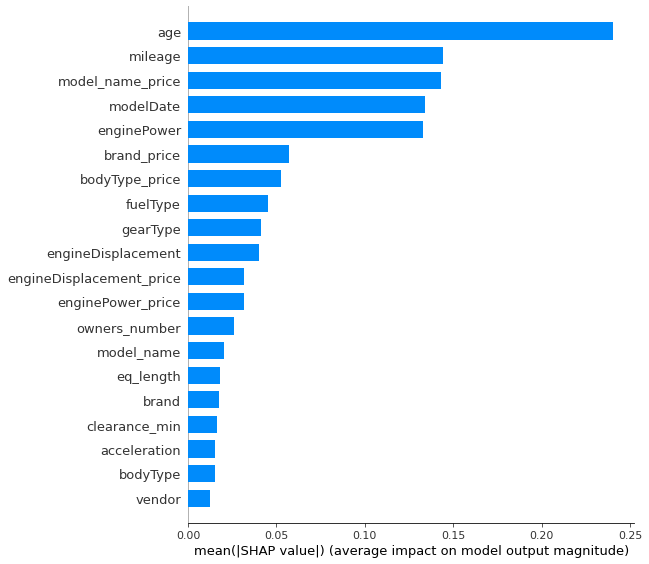

In [201]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)


shap_values = explainer.shap_values(Pool(X_train, y_train))


# feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Submissions blend

In [202]:
def cat_model(y_train, X_train, X_val, y_val):
    model = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              eval_metric='MAPE',
                              random_seed=RANDOM_SEED,)
    model.fit(X_train, y_train,
              # cat_features=cat_features_ids,
              eval_set=(X_val, y_val),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)

In [210]:
# куда пишем предикты по каждой модели
submissions = pd.DataFrame(0, columns=["sub_1"], index=sample_submission.index)
score_ls = []
splits = list(RepeatedKFold(n_repeats=3, n_splits=N_FOLDS,
                            random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS*3,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_val, y_val = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_val, y_val,)
    # score model on test
    test_predict = model.predict(X_val)
    test_score = mape(y_val, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_val, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_test)
    model.save_model(f'catboost_fold_{idx+1}.model')

print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')
# Mean Score: 12.302
# Std Score: 0.2742
# Max Score: 13.109
# Min Score: 11.929

1 Fold Test MAPE: 12.224
2 Fold Test MAPE: 12.147
3 Fold Test MAPE: 13.109
4 Fold Test MAPE: 12.056
5 Fold Test MAPE: 12.096
6 Fold Test MAPE: 12.588
7 Fold Test MAPE: 12.316
8 Fold Test MAPE: 12.275
9 Fold Test MAPE: 12.117
10 Fold Test MAPE: 12.393
11 Fold Test MAPE: 11.929
12 Fold Test MAPE: 12.509
13 Fold Test MAPE: 12.165
14 Fold Test MAPE: 12.394
15 Fold Test MAPE: 12.210

Mean Score: 12.302
Std Score: 0.2742
Max Score: 13.109
Min Score: 11.929


In [204]:
submissions = np.exp(submissions)
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,sub_10,sub_11,sub_12,sub_13,sub_14,sub_15
0,7.200069e+05,7.094912e+05,7.110272e+05,7.022615e+05,7.094075e+05,7.003922e+05,7.200464e+05,7.072692e+05,7.175231e+05,7.213193e+05,7.167571e+05,7.018391e+05,7.164429e+05,7.170058e+05,7.374619e+05
1,9.970505e+05,9.873114e+05,1.022661e+06,9.906069e+05,1.003624e+06,9.568543e+05,1.009032e+06,1.010294e+06,1.003341e+06,9.802542e+05,9.822555e+05,1.015707e+06,9.963650e+05,1.006002e+06,1.013197e+06
2,9.727723e+05,9.904372e+05,9.788864e+05,9.266529e+05,9.489985e+05,1.000444e+06,9.827546e+05,9.533901e+05,9.812080e+05,9.769556e+05,9.550235e+05,9.715253e+05,9.935259e+05,9.846078e+05,9.666933e+05
3,8.212515e+05,8.278346e+05,8.136580e+05,8.183984e+05,8.138208e+05,8.393527e+05,8.067516e+05,8.298599e+05,8.089132e+05,8.236346e+05,8.083158e+05,8.120068e+05,8.203162e+05,8.345159e+05,8.057447e+05
4,7.529001e+05,7.414319e+05,7.435118e+05,7.460308e+05,7.236198e+05,7.412701e+05,7.585352e+05,7.421135e+05,7.251930e+05,7.304267e+05,7.385017e+05,7.611651e+05,7.300351e+05,7.344579e+05,7.479135e+05
5,7.727362e+05,8.305364e+05,7.953386e+05,7.753815e+05,7.976516e+05,8.162550e+05,7.933952e+05,8.076310e+05,8.084462e+05,7.857042e+05,7.857214e+05,8.000738e+05,7.879616e+05,7.975852e+05,8.036926e+05
6,7.002754e+05,6.934525e+05,7.100553e+05,7.022580e+05,6.942649e+05,6.968950e+05,6.952799e+05,6.895872e+05,6.923550e+05,7.012038e+05,7.044636e+05,7.100959e+05,6.870970e+05,7.007104e+05,7.100944e+05
7,4.524732e+05,4.683140e+05,4.659535e+05,4.753361e+05,4.683580e+05,4.790397e+05,4.538113e+05,4.785038e+05,4.806828e+05,4.772441e+05,4.728546e+05,4.639409e+05,4.842766e+05,4.668866e+05,4.690783e+05
8,2.068217e+06,2.123442e+06,2.092632e+06,2.118667e+06,2.104022e+06,2.097940e+06,2.127207e+06,2.126833e+06,2.064811e+06,2.111475e+06,2.115524e+06,2.126981e+06,2.077900e+06,2.090705e+06,2.071982e+06
9,8.143744e+05,8.096389e+05,8.076476e+05,8.436921e+05,8.226410e+05,8.162386e+05,7.988349e+05,8.111798e+05,8.089375e+05,8.225901e+05,7.993018e+05,8.246376e+05,8.066210e+05,8.063343e+05,8.215437e+05


In [205]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = price_deflator*submissions['blend'].values
sample_submission.to_csv(f'submission_blend_v{3}.csv', index=False)
sample_submission.head(
    10)  # submission rate - 15.76% после учета инфляции - 13.68 %
# после учета инфляции - 13.57708 - best result

,sell_id,price
0,1100575026,6.702787e+05
1,1100549428,9.373262e+05
2,1100658222,9.128718e+05
3,1100937408,7.689355e+05
4,1101037972,6.958708e+05
5,1100912634,7.485131e+05
6,1101228730,6.564976e+05
7,1100165896,4.417146e+05
8,1100768262,1.972878e+06
9,1101218501,7.645437e+05


### LightGBM

#### CV LightGBM

In [310]:
model = LGBMRegressor(learning_rate=0.05, max_depth=30,
                      n_estimators=1000, num_leaves=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f"LightGBM Test MAPE: {mape(y_val, y_pred):0.4f}%")
# LightGBM Test MAPE: 12.29% - deflated submission 13.99 %

LightGBM Test MAPE: 12.4475%


### XGBoost

#### CV XGBoost

In [207]:
model = XGBRegressor(verbosity=1, learning_rate=0.1,
                     max_depth=7, n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f"XGBM Test MAPE: {mape(y_val, y_pred):0.4f}%")

# XGBM Test MAPE: 12.3817% submission rate 14.03344%

XGBM Test MAPE: 12.3817%


### Stacking

In [74]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


def compute_metric(regr, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    regr.fit(X_train, y_train)
    y_val_pred = regr.predict(X_val)
    return np.round(mape(y_val, y_val_pred), 4)


def compute_meta_feature(regr, X_train, X_val, y_train, cv, X_test):

    X_meta_train = np.zeros_like(y_train, dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_val)
    X_meta_pred = meta_regr.predict(X_test)

    return X_meta_train, X_meta_test, X_meta_pred


def generate_meta_features(regr_s, X_train, X_val, y_train, cv, X_test):

    features = [compute_meta_feature(
        regr, X_train, X_val, y_train, cv, X_test) for regr in tqdm(regr_s)]
    stacked_features_train = np.vstack(
        [features_train for features_train, features_test, features_pred in features]).T
    stacked_features_test = np.vstack(
        [features_test for features_train, features_test, features_pred in features]).T
    stacked_features_pred = np.vstack(
        [features_pred for features_train, features_test, features_pred in features]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

Base models:  {XGBr, LGBMr, RFr, CBr}, 
Meta_model: Ridge

In [75]:
stacked_features_train, stacked_features_val, stacked_features_test = generate_meta_features([
    (XGBRegressor(verbosity=0,
                  n_estimators=1000, max_depth=7, learning_rate=0.1, n_jobs=-1)),
    (LGBMRegressor(learning_rate=0.05,
                   max_depth=30, n_estimators=1000, num_leaves=25, n_jobs=-1)),
    (RandomForestRegressor(n_estimators=350,
                           criterion='mse', min_samples_leaf=10, n_jobs=-1)),
    (CatBoostRegressor(verbose=0, iterations=1000,
                       learning_rate=0.15,
                       depth=8,
                       random_seed=RANDOM_SEED,
                       eval_metric='MAPE',
                       custom_metric=['RMSE']))], X_train.values, X_val.values, y_train.values, cv, X_test.values)

In [96]:
meta_model = Ridge(random_state=RANDOM_SEED)
print(f'Stacking MAPE = {compute_metric(meta_model, X_train=stacked_features_train, y_train=y_train, X_val=stacked_features_val, y_val=y_val)}%')

Stacking MAPE = 12.0391%


In [ ]:
X_test = stacked_features_test
model = meta_model  # for making further submission

Stacking улучшил MAPE на валидации, но на тестовой выборке чуть-чуть недотянул (13.83%) до лучшего результата (13.58%) от блэндинга CatBoost моделей

## Make submission

In [226]:
y_pred = model.predict(X_test)
predict_submission = y_pred  # model.predict(X_test)

sample_submission['price'] = price_deflator*np.exp(predict_submission)
sample_submission.to_csv(f'submission_v{3}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.984901e+05
1,1100549428,9.711151e+05
2,1100658222,9.111033e+05
3,1100937408,8.105852e+05
4,1101037972,6.868725e+05
5,1100912634,7.332334e+05
6,1101228730,6.465542e+05
7,1100165896,4.325176e+05
8,1100768262,1.933039e+06
9,1101218501,7.311915e+05


### Итоги

1. Очень трудоемкий парсинг, есть неуверенность в правильности некоторых данных,
так как бинарный признак complection_dict оказался распределен в трейне не так, как в тесте и имел практически нулевую значимость. 
2. Перепробованы различные композитные признаки, однако существенных улучшений не получилось (в пределах одного процента)
3. Основное улучшение (около двух процентов) произошло за счет применения дефлятора предсказаний.
4. Указание категориальных признаков почему-то ухудшало (хотя и незначительно) результат CatBoost.
5. Лучший результат показало усреденение предсказаний CatBoost (Submissions blend)
6. Возможно, обработка текстовых признаков и комплектации смогла бы улучшить результат.
Итого: MAPE = 13.57708 % - best result